# MAST30034_Applied Data Science_Project1

## Import Libraries

In [199]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from geodatasets import get_path
import pandas as pd
import geopandas as gpd
from pyspark.sql.functions import date_format, hour, dayofweek
import seaborn as sns
from scipy.stats import chi2_contingency
from pyspark.sql.functions import count as spark_count
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pyarrow as pa
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [200]:
# Create a spark session
spark = (
SparkSession.builder.appName("ADS project 1")
.config("spark.sql.repl.eagerEval.enabled", True)
.config("spark.driver.memory","6G")
.config("spark.executor.memory","6G")
.config("spark.sql.parquet.cacheMetadata", "true")
.getOrCreate()
)

## Read the data

In [201]:
taxi_data_9 = spark.read.parquet('../data/after_EDA_data_Engineering/taxi-9').toPandas()
citybike_data_9 = spark.read.parquet('../data/after_EDA_data_Engineering/citybike-9').toPandas()
taxi_data_2 = spark.read.parquet('../data/after_EDA_data_Engineering/taxi-2').toPandas()
citybike_data_2 = spark.read.parquet('../data/after_EDA_data_Engineering/citybike-2').toPandas()

## One hot encoding

In [202]:
def one_hot_encode(train_df, test_df, columns_to_encode):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    train_encoded = encoder.fit_transform(train_df[columns_to_encode])
    train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(columns_to_encode))
    train_df = pd.concat([train_df.drop(columns_to_encode, axis=1), train_encoded_df], axis=1)
    test_encoded = encoder.transform(test_df[columns_to_encode])
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(columns_to_encode))
    test_df = pd.concat([test_df.drop(columns_to_encode, axis=1), test_encoded_df], axis=1)
    
    return train_df, test_df

In [203]:
# the function use to do the log transform
def log_transform(train_df, test_df, columns_to_transform):
    train_df[columns_to_transform] = train_df[columns_to_transform].astype(float)
    test_df[columns_to_transform] = test_df[columns_to_transform].astype(float)
    
    # 对指定列进行对数变换
    for column in columns_to_transform:
        train_df[column] = np.log1p(train_df[column])
        test_df[column] = np.log1p(test_df[column])
    
    return train_df, test_df

In [204]:
# The function use to do the min-max scale
def normalize_data(train_df, test_df, columns_to_normalize):
    scaler = MinMaxScaler()
    train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
    test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])
    return train_df, test_df

In [205]:
taxi_data_9, taxi_data_2 = one_hot_encode(taxi_data_9, taxi_data_2, ['hour','preciptype','icon','day_of_week'])
taxi_data_9, taxi_data_2 = log_transform(taxi_data_9, taxi_data_2,['windgust','visibility','solarenergy'])
taxi_data_9, taxi_data_2 = normalize_data(taxi_data_9, taxi_data_2,['temp', 'humidity', 'windgust', 'visibility', 'solarenergy'])

In [206]:
citybike_data_9, citybike_data_2 = one_hot_encode(citybike_data_9, citybike_data_2, ['hour','uvindex'])
citybike_data_9, citybike_data_2 = log_transform(citybike_data_9, citybike_data_2,['windgust','visibility','solarenergy','severerisk'])
citybike_data_9, citybike_data_2 = normalize_data(citybike_data_9, citybike_data_2,['temp', 'humidity', 'windgust', 'visibility', 'solarenergy','severerisk','dew','cloudcover'])

In [207]:
taxi_data_9.shape

(6551, 49)

In [208]:
taxi_data_2.shape

(1489, 49)

In [209]:
citybike_data_9.shape

(6551, 44)

In [210]:
citybike_data_2.shape

(1489, 44)

## Linear regression model

In [211]:
# The function use to do the linear regression
def linear_regression_with_cv(train_df_pd, test_df_pd, goal):
    train_df = spark.createDataFrame(train_df_pd)
    test_df = spark.createDataFrame(test_df_pd)
    features_columns = [col for col in train_df.columns if col != goal]
    assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)
    lr = LinearRegression(featuresCol="features", labelCol=goal)
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
        .build()
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=goal, metricName="rmse")
    crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=5)
    cvModel = crossval.fit(train_df)
    test_predictions = cvModel.transform(test_df)
    rmse = evaluator.evaluate(test_predictions)
    r2 = RegressionEvaluator(predictionCol="prediction", labelCol=goal, metricName="r2").evaluate(test_predictions)
    
    print(f"Test Data RMSE: {rmse}")
    print(f"Test Data R2: {r2}")
    test_predictions_pd = test_predictions.select("prediction", goal).toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(test_predictions_pd[goal], test_predictions_pd["prediction"], color='blue', alpha=0.5, label='Data points')
    
    m, b = np.polyfit(test_predictions_pd[goal], test_predictions_pd["prediction"], 1)
    plt.plot(test_predictions_pd[goal], m * test_predictions_pd[goal] + b, color='red', linewidth=2, label='Best fit line')
    
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Linear Regression - Actual vs Predicted")
    plt.legend()
    plt.show()


Test Data RMSE: 1222.6122746733256
Test Data R2: 0.7673225598828041


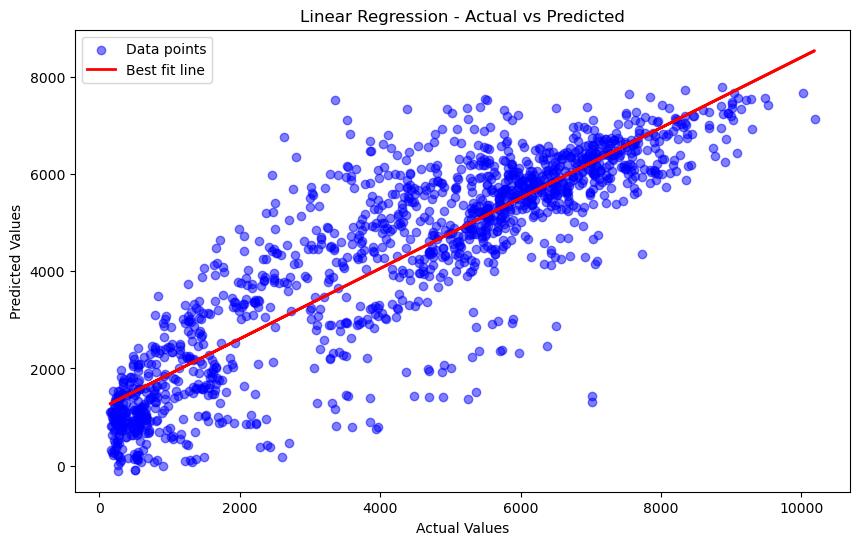

In [212]:
linear_regression_with_cv(taxi_data_9, taxi_data_2, 'taxi_count')

Test Data RMSE: 1552.51108081659
Test Data R2: 0.6687633473242125


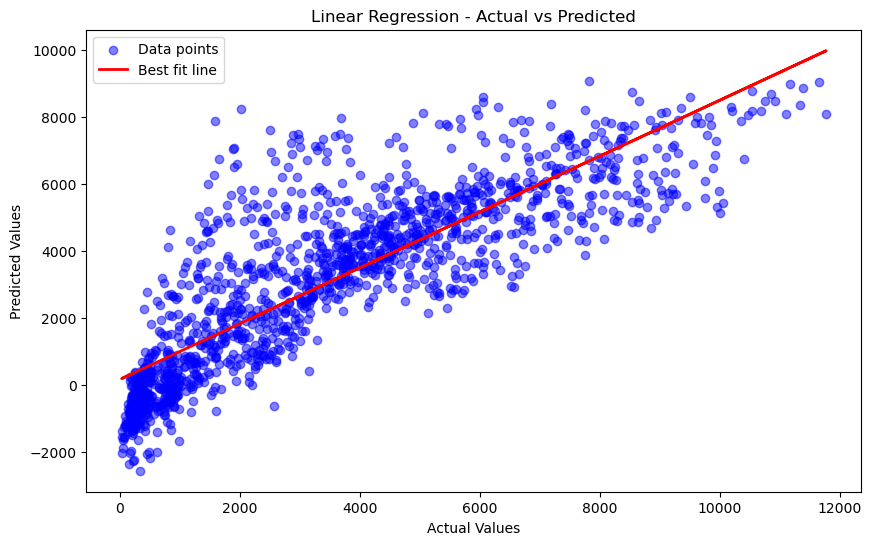

In [213]:
linear_regression_with_cv(citybike_data_9, citybike_data_2, 'citybike_count')

## Random forest model

In [214]:
def randomForestRegressor(train_data, val_data, goal, depth_range=range(1, 21)):
    X_train = train_data.drop(columns=[goal])
    y_train = train_data[goal]
    X_val = val_data.drop(columns=[goal])
    y_val = val_data[goal]
    
    results = {'depth': [], 'train_score': [], 'test_score': []}
    # 交叉验证以选择最佳深度
    for depth in depth_range:
        rf = RandomForestRegressor(max_depth=depth, max_features='sqrt',
                                   bootstrap=False, random_state=42, n_estimators=100)
        cv_results = cross_validate(rf, X_train, y_train, cv=5, return_train_score=True, scoring='r2')
        train_mean = cv_results['train_score'].mean()
        test_mean = cv_results['test_score'].mean()
        results['depth'].append(depth)
        results['train_score'].append(train_mean)
        results['test_score'].append(test_mean)
    
    # 将结果转换为DataFrame并找到最佳深度
    results_df = pd.DataFrame(results)
    max_test_score_row = results_df.loc[results_df['test_score'].idxmax()]
    best_depth = int(max_test_score_row['depth']) 

    # 使用最佳深度重新训练模型
    best_rf = RandomForestRegressor(max_depth=best_depth, max_features='sqrt',
                                    bootstrap=False, random_state=42, n_estimators=100)
    best_rf.fit(X_train, y_train)
    
    # 在验证集上进行预测
    y_val_pred = best_rf.predict(X_val)
    
    # 计算验证集上的R²分数
    r2_score_val = r2_score(y_val, y_val_pred)
    print(f'Validation R² with best depth={best_depth}: {r2_score_val}')
    
    # 计算并打印均方根误差
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    
    # 绘制模型深度与训练/测试R²的关系图
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['depth'], results_df['train_score'], label='Training R²', marker='o', color='blue')
    plt.plot(results_df['depth'], results_df['test_score'], label='Testing R²', marker='s', linestyle='--', color='red')
    plt.xlabel('Depth')
    plt.ylabel('R²')
    plt.title('Random Forest R² vs. Depth')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_depth, r2_score_val

Validation R² with best depth=20: 0.785528323499894
Root Mean Squared Error (RMSE): 1173.806706274646


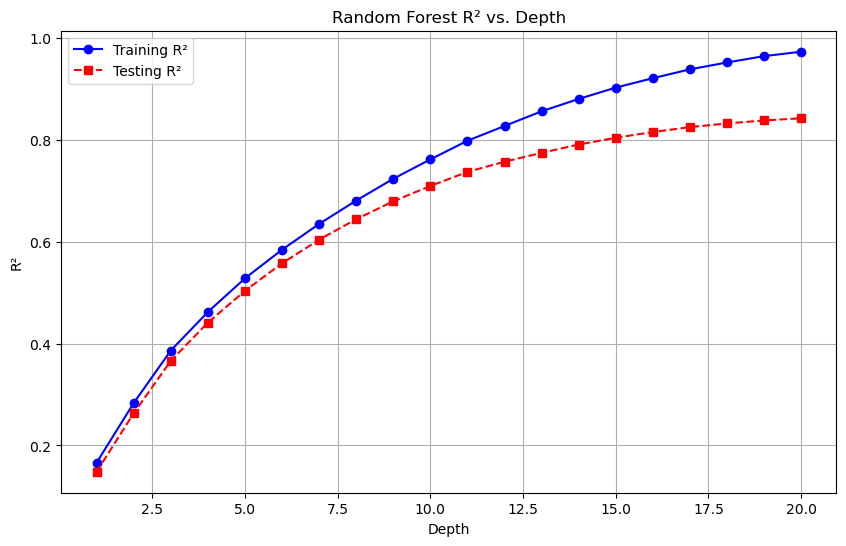

(20, 0.785528323499894)

In [215]:
randomForestRegressor(taxi_data_9, taxi_data_2, 'taxi_count')

Validation R² with best depth=20: 0.7049174699668537
Root Mean Squared Error (RMSE): 1465.3361511834378


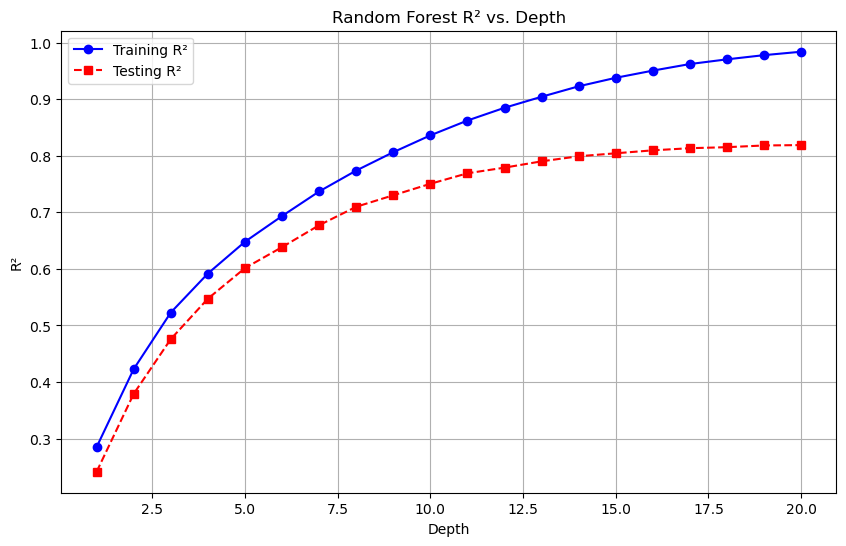

(20, 0.7049174699668537)

In [216]:
randomForestRegressor(citybike_data_9, citybike_data_2, 'citybike_count')